# Comparing ideal distances with pixel distances
This code samples points on the generating cycles for each symmetry group, and then creates a distance matrix with the idealized distance function, and a distance matrix with the pixel embedding distance function. This is to determine how "far off" our pixel embedding point cloud is for each group. 

In [170]:
# importing needed libraries
import numpy as np
from numpy import pi
from math import dist
from math import sqrt
from math import ceil
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
# For image and video manipulation
from PIL import Image
from PIL import ImageFilter
from IPython.display import display
import glob
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from matplotlib import cm

In [180]:
# defining the idealized distance function for C1
def C1_wrapper(a,b):
    def distance_C1(x, y):
        Y = []
        options = [-1,0,1]
        for option_a in options:
            for option_b in options:
                for option_c in options:
                    Y.append([y[0] + a[0] * option_a + b[0] * option_b, y[1] + a[1] * option_a + b[1] * option_b, y[2] + 2*pi * option_c])

        distances = []
        for y_new in Y: 
            distances.append(dist(x,y_new))

        return min(distances)
    return distance_C1

generate_C1_isoms() samples points on the generating cycles for $C1$.

In [37]:
def generate_C1_isoms(n_isos, a, b):
    j = ceil(n_isos / 3)
    isoms = []
    steps_x = np.linspace(0, a, j)
    steps_y = np.linspace(0, b, j)
    steps_rot = np.linspace(0, 2*pi, j)
    
    for elem in steps_rot:
        isoms.append((0 , 0, elem))    

    for elem in steps_x:
        isoms.append((elem, 0, 0))
        
    for elem in steps_y:
        isoms.append((0, elem, 0))
        
    return isoms

In [181]:
# idealized C2 distance function
def C2_wrapper(a,b):
    def distance_C2(x, y):

        # no rotations
        Y = []
        options = [-1,0,1]
        for option_a in options:
            for option_b in options:
                Y.append([y[0] + a[0] * option_a + b[0] * option_b, y[1] + a[1] * option_a + b[1] * option_b, y[2]])

        # rotate by pi
        options = [-1,0,1]
        for option_a in options:
            for option_b in options:
                Y.append([a[0] + b[0] - y[0] + a[0] * option_a + b[0] * option_b, a[1] + b[1] - y[1] + a[1] * option_a + b[1] * option_b, y[2] + pi])

        # rotate by -pi
        options = [-1,0,1]
        for option_a in options:
            for option_b in options:
                Y.append([a[0] + b[0] - y[0] + a[0] * option_a + b[0] * option_b, a[1] + b[1] - y[1] + + a[1] * option_a + b[1] * option_b, y[2] - pi])

        distances = []
        for y_new in Y: 
            distances.append(dist(x,y_new))

        return min(distances)
    return distance_C2

generate_C2_isoms() samples points on the generating cycles for $C2$.

In [38]:
def generate_C2_isoms(n_isos, a, b):
    j = ceil(n_isos / 3)
    isoms = []
    steps_x = np.linspace(0, a, j)
    steps_y = np.linspace(0, b, j)
    steps_rot = np.linspace(0, pi, j)
    
    for elem in steps_rot:
        isoms.append((0 , 0, elem))    

    for elem in steps_x:
        isoms.append((elem, 0, 0))
        
    for elem in steps_y:
        isoms.append((0, elem, 0))
        
    return isoms

In [182]:
# idealized distance function for C4
def C4_wrapper(a): 
    def distance_C4(x, y):

        # no rotation
        Y = []
        options = [-1,0,1]
        for option_1 in options:
            for option_2 in options:
                Y.append([y[0] + a * option_1, y[1] + a * option_2, y[2]])

        # rotate by pi/2
        options = [-1,0,1]
        for option_1 in options:
            for option_2 in options:
                Y.append([a - y[1] + a * option_1, y[0] + a * option_2, y[2] + pi/2])

        # rotate by -pi/2
        options = [-1,0,1]
        for option_1 in options:
            for option_2 in options:
                Y.append([y[1] + a * option_1, -y[0] + a + a * option_2, y[2] - pi/2])

        distances = []
        for y_new in Y: 
            distances.append(dist(x,y_new))

        return min(distances)
    return distance_C4

generate_C4_isoms() samples points on the generating cycles for $C4$.

In [60]:
# isometries that allow rotation up to pi/2
def generate_C4_isoms(n_isos, a):
    j = ceil(n_isos / 3)
    isoms = []
    steps_trans = np.linspace(0, a, j)
    steps_rot = np.linspace(0, pi/2, j)
    
    for elem in steps_rot:
        isoms.append((0 , 0, elem))    

    for elem in steps_trans:
        isoms.append((elem, 0, 0))
        
    for elem in steps_trans:
        isoms.append((0, elem, 0))
        
    return isoms

Helper functions for $C_3$ and $C_6$ distance functions to ensure that points are on the fundamental hexagon before calculation.

In [195]:
def add_vectors(a,x,b,y):
    ax_plus_by = [0,0,0]
    ax_plus_by = [a*x[0] + b*y[0], a*x[1] + b*y[1],a*x[2] + b*y[2]]
    return ax_plus_by

def point_in_hex(x, a):
    
    v1 = (3/2 * a, sqrt(3)/2 * a, 0 )
    v2 = (3/2 * a, -sqrt(3)/2 * a, 0 )
    v3 = (0,0,2*pi/3)
    x_coeff = np.linalg.solve(np.column_stack((v1,v2,v3)), x)
    
    if abs(x_coeff[0]) > 0.5:
        if x_coeff[0]<0:
            x_coeff[0] = -1 * ceil(abs(x_coeff[0]))
        else: 
            x_coeff[0] = ceil(x_coeff[0])
    else: 
        x_coeff[0]= 0 
    
    if abs(x_coeff[1]) > 0.5:
        if x_coeff[1]<0:
            x_coeff[1] = -1 * ceil(abs((x_coeff[1])))
        else: 
            x_coeff[1] = ceil(x_coeff[1])
    else: 
        x_coeff[1] = 0
    
    if abs(x_coeff[2]) > 0.5:
        if x_coeff[2]<0:
            x_coeff[2] = -1 * ceil((abs(x_coeff[2])))
        else: 
            x_coeff[2] = ceil(x_coeff[2])
    else: 
        x_coeff[2] = 0
    
    x = add_vectors(1,x,-x_coeff[0], v1)
    x = add_vectors(1,x,-x_coeff[1], v2)
    x = add_vectors(1,x,-x_coeff[2], v3)

    return x

points_on_line() generates points on a line between two given points. This is a helper function for generate_C6_isoms().

In [172]:
def points_on_line(point1, point2, n):
    point1 = np.asarray(point1)
    point2 = np.asarray(point2)
    direction = point2-point1  
    ret_arr = []
    t = np.linspace(0,1,n)
    for i in t:
        ret_arr.append(direction*i + point1)
    return ret_arr

In [196]:
# idealized distance function for C3
def C3_wrapper(a):   
    def distance_C3(x, y):

        x = point_in_hex(x,a)
        y = point_in_hex(y,a)

        # no translation in rotation axis
        Y = [y] # no translation in any axis
        for i in [1,-1]:
            Y.append((y[0], y[1] + i * (3**0.5) * a, y[2])) # front and back
            Y.append((y[0] + i * (3/2) * a, y[1] + i * - (3**0.5)/2 * a, y[2])) # LB and RF
            Y.append((y[0] + i * (3/2) * a, y[1] + i * (3**0.5)/2 * a, y[2])) # LF and RB

        # rotate by 2*pi/3
        y1 = -1/2 * y[0] - (3**0.5)/2 * y[1]
        y2 = -1/2 * y[1] + (3**0.5)/2 * y[0] 
        Y.append((y1, y2, y[2] + 2*pi/3)) # only rotation by 2pi/3
        for i in [1,-1]:
            Y.append((y1, y2 + i * (3**0.5) * a, y[2]+2*pi/3)) # front and back
            Y.append((y1 + i * (3/2) * a, y2 + i * - (3**0.5)/2 * a, y[2]+2*pi/3)) # LB and RF
            Y.append((y1 + i * (3/2) * a, y2 + i * (3**0.5)/2 * a, y[2]+2*pi/3)) # LF and RB

        # rotate by -2*pi/3
        y1 = -1/2 * y[0] + (3**0.5)/2 * y[1]
        y2 = -1/2 * y[1] - (3**0.5)/2 * y[0]
        Y.append((y1, y2, y[2] - 2*pi/3)) # only rotation by -2pi/3
        for i in [1,-1]:
            Y.append((y1, y2 + i * (3**0.5) * a, y[2]-2*pi/3)) # front and back
            Y.append((y1 + i * (3/2) * a, y2 + i * - (3**0.5)/2 * a, y[2]-2*pi/3)) # LB and RF
            Y.append((y1 + i * (3/2) * a, y2 + i * (3**0.5)/2 * a, y[2]-2*pi/3)) # LF and RB

        distances = []
        for y_new in Y:
            distances.append(dist(x,y_new))

        return min(distances)

    return distance_C3

generate_C3_isoms() samples points on the generating cycles for $C3$.

In [197]:
# allow only for rotations up to 2pi/3
def generate_C3_isoms(n_isos, a):
    j = ceil(n_isos / 4)
    isoms = []
    tri = (sqrt(3) / 2)
    steps = np.linspace(0, a, j)
    
    rotation = np.linspace(0, (2 * pi /3), j)
    for elem in rotation:
        isoms.append((0, 0, elem))
         
    for elem in steps: # Front & back 
        isoms.append((0,elem * 3**0.5, 0))
        
    for elem in steps: # LB & RF
        isoms.append((elem * 1.5 , -(3**.5)/2* elem, 0))
 
    for elem in steps: # LF & RB
        isoms.append((elem * 1.5, (3**.5)/2 * elem, 0))

        
    return isoms 

In [207]:
# idealized distance function for C6
def C6_wrapper(a):   
    def distance_C6(x, y):

        x = point_in_hex(x,a)
        y = point_in_hex(y,a)

        # no translation in rotation axis
        Y = [y] # no translation in any axis
        for i in [1,-1]:
            Y.append((y[0], y[1]+ i * (3**0.5) * a, y[2])) # front and back
            Y.append((y[0] + i * (3/2) * a, y[1] - (3**0.5)/2 * a, y[2])) # LB and RF
            Y.append((y[0] + i * (3/2) * a, y[1] + (3**0.5)/2 * a, y[2])) # LF and RB

        # rotate by pi/3
        y1 = 1/2 * y[0] - (3**0.5)/2 * y[1]
        y2 = 1/2 * y[1] + (3**0.5)/2 * y[0] 
        Y.append((y1, y2, y[2] + pi/3)) # only rotation by pi/3
        for i in [1,-1]:
            Y.append((y1, y2+ i * (3**0.5) * a, y[2]+pi/3)) # front and back
            Y.append((y1 + i * (3/2) * a, y2 - (3**0.5)/2 * a, y[2]+pi/3)) # LB and RF
            Y.append((y1 + i * (3/2) * a, y2 + (3**0.5)/2 * a, y[2]+pi/3)) # LF and RB 

        # rotate by -pi/3
        y1 = 1/2 * y[0] + (3**0.5)/2 * y[1]
        y2 = 1/2 * y[1] - (3**0.5)/2 * y[0]
        Y.append((y1, y2, y[2] - pi/3)) # only rotation by -pi/3
        for i in [1,-1]:
            Y.append((y1, y2+ i * (3**0.5) * a, y[2]-pi/3)) # front and back
            Y.append((y1 + i * (3/2) * a, y2 - (3**0.5)/2 * a, y[2]-pi/3)) # LB and RF
            Y.append((y1 + i * (3/2) * a, y2 + (3**0.5)/2 * a, y[2]-pi/3)) # LF and RB 

        distances = []
        for y_new in Y: 
            distances.append(dist(x,y_new))

        return min(distances)
    return distance_C6

generate_C6_isoms() samples points on the generating cycles for $C6$.

In [208]:
# only allow rotation up to pi/3
def generate_C6_isoms(n_isos, x):
    j = ceil(n_isos / 4)
    isoms = []
    tri = (sqrt(3) / 2)
    steps = np.linspace(0, a, j)
    
    rotation = np.linspace(0, (pi /3), j)
    for elem in rotation:
        isoms.append((0, 0, elem))
    
    for elem in steps: # Front & back 
        isoms.append((0,elem * 3**0.5, 0))    
    
    for elem in steps: # LB & RF
        isoms.append((elem * 1.5 , -tri * elem, 0))    

    for elem in steps: # LF & RB
        isoms.append((elem * 1.5, tri * elem, 0))
        
    return isoms

Given an image, a lens size, and a translation, this translation_snapshot() returns a snapshot after the translation is performed.

In [31]:
def translation_snapshot(img, lens_sz, translation):
    (a,b) = translation 
    translation = (-a,-b)
    (x,y) = upper_left_center(img, translation)
    (length, height) = img.size
    
    lens_corner_x = x - lens_sz/2.0 
    lens_corner_y = y - lens_sz/2.0 
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lens_sz, lens_corner_y+lens_sz))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
    if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lens_sz>length or lens_corner_y+lens_sz>height):
        print("I came off the page!")
        return False
    return ret_img

Given a point with the origin at the center of the image, upper_left_center() returns the same point but with coordinates with an origin at the top left corner. This is a helper function for translation_snapshot().

In [32]:
def upper_left_center(img, center):
    (x,y) = center
    (l, h) = img.size
    return (l/2.0+x , h/2.0 - y) 

Given an image, a lens size, and an isometry, create_snapshot() performs the isometry on the image and returns a lens size view of the image

In [33]:
def create_snapshot(img, lens_sz, isometry):
    (x,y,rotation) = isometry
    translation = (x,y)
    # turn from radian to degree
    rotation = 57.2958*rotation
    rot_img = img.rotate(rotation)
    return translation_snapshot(rot_img, lens_sz, translation)

get_pixel_isom() converts a list of isometries into a list of the associated pixel vector embeddings. It scales the translations by the fundamental domain or given lens size (that way inistead of translating $a$ pixels, it travels 20 for instance).

In [47]:
def get_pixel_isom(isoms, img, lens, a):
    scaled_isoms = isoms
    for i in range(len(isoms)):
        e = isoms[i]
        scaled_isoms[i] = ((lens/a)*e[0], (lens/a)*e[1], e[2])
    isom_images = []
    for iso in scaled_isoms:
        isom_images.append(create_snapshot(img, lens, iso))
    ret_lst = []
    for elem in isom_images:
        arr = np.asarray(elem)
        arr = arr.reshape(-1)
        ret_lst.append(arr)
    ret_lst = np.asarray(ret_lst)
    return ret_lst

This is the "new" normalize() function that scales a matrix such that the largest value is 1.

In [135]:
def normalize(v):
    v = np.asarray(v)
    norm = v.max()
    if norm == 0: 
        return v
    return v / norm

create_plt() plots an ideal and a pixel matrix

In [129]:
def create_plt(ideal, pixel):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.colorbar(plt.cm.ScalarMappable(), ax=(ax1,ax2), label="colorscale", shrink=.4)
    ax1.imshow(ideal)
    ax1.set_title("ideal")
    ax2.imshow(pixel)
    ax2.set_title("pixel")
    plt.show()

# C4 Comparison

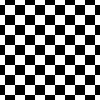

distance between metrics:  151.41845070070408


<Figure size 640x480 with 0 Axes>

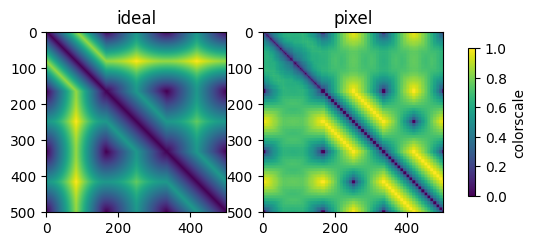

In [192]:
# Grab image from files
img = Image.open('images/smallcheck.jpeg')
img = img.convert('L')
img = translation_snapshot(img, 100, (5.349, -4.967))
display(img)

# lens size, how much to stretch fund domain by
fund_domain = 20
a = 1
n_isoms = 500
c4_isoms_pixels = get_pixel_isom(generate_C4_isoms(n_isoms,a), img, fund_domain, a)

D_ideal = pairwise_distances(generate_C4_isoms(n_isoms,a), metric = C4_wrapper(a))
D_pixel = pairwise_distances(c4_isoms_pixels)
D_ideal = normalize(D_ideal)
D_pixel = normalize(D_pixel)

print("distance between metrics: ", dist(D_ideal.reshape(-1),D_pixel.reshape(-1)))
create_plt(D_ideal, D_pixel)


There are some similar features between the two matrices and the cycles are faint but visible in the pixel matrix.

Here is the same thing but with the value of $a$ increased to 7 instead of 1:

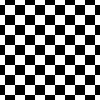

distance between metrics:  125.65415908315988


<Figure size 640x480 with 0 Axes>

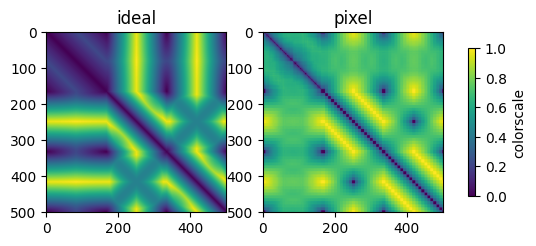

In [193]:
# Grab image from files
img = Image.open('images/smallcheck.jpeg')
img = img.convert('L')
img = translation_snapshot(img, 100, (5.349, -4.967))
display(img)

# lens size, how much to stretch fund domain by
fund_domain = 20
a = 7
n_isoms = 500
c4_isoms_pixels = get_pixel_isom(generate_C4_isoms(n_isoms,a), img, fund_domain, a)

D_ideal = pairwise_distances(generate_C4_isoms(n_isoms,a), metric = C4_wrapper(a))
D_pixel = pairwise_distances(c4_isoms_pixels)
D_ideal = normalize(D_ideal)
D_pixel = normalize(D_pixel)

print("distance between metrics: ", dist(D_ideal.reshape(-1),D_pixel.reshape(-1)))
create_plt(D_ideal, D_pixel)

The upper right corner represents rotations, and so increasing the length of the translation cycles made the rotation cycles relatively faint. The pixel matrix is very clear and has similar features to the ideal matrices. 

# C2 Comparison

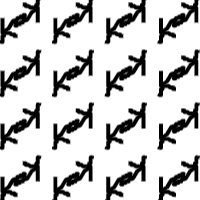

distance between metrics:  260.6013843050237


<Figure size 640x480 with 0 Axes>

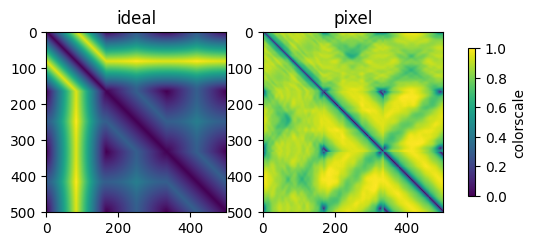

In [149]:
# Grab image from files
img = Image.open('images/squareC2.png')
img = img.convert('L')
# center image around center of rotation
img = translation_snapshot(img, 200, (26.752, -6.824))
display(img)

# lens size, how much to stretch fund domain by
fund_domain = 56
a = 1
n_isoms = 500
c2_isoms_pixels = get_pixel_isom(generate_C2_isoms(n_isoms, a, a), img, fund_domain, a)

D_ideal = pairwise_distances(generate_C2_isoms(n_isoms, a, a), metric = C2_wrapper((a,0),(0,a)))
D_pixel = pairwise_distances(c2_isoms_pixels)
D_ideal = normalize(D_ideal)
D_pixel = normalize(D_pixel)
print("distance between metrics: ", dist(D_ideal.reshape(-1),D_pixel.reshape(-1)))
create_plt(D_ideal, D_pixel)

Looks like the value of $a$ needs to be increased, since the rotation cycles are much more prominent. Set $a=4$ instead of $a=1$:

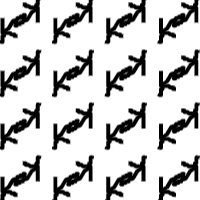

distance between metrics:  208.90772973140292


<Figure size 640x480 with 0 Axes>

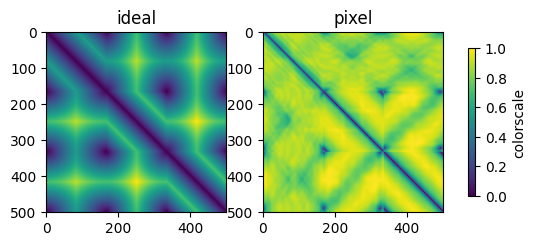

In [150]:
# Grab image from files
img = Image.open('images/squareC2.png')
img = img.convert('L')
# center image around center of rotation
img = translation_snapshot(img, 200, (26.752, -6.824))
display(img)

# lens size, how much to stretch fund domain by
fund_domain = 56
a = 4
n_isoms = 500
c2_isoms_pixels = get_pixel_isom(generate_C2_isoms(n_isoms, a, a), img, fund_domain, a)

D_ideal = pairwise_distances(generate_C2_isoms(n_isoms, a, a), metric = C2_wrapper((a,0),(0,a)))
D_pixel = pairwise_distances(c2_isoms_pixels)
D_ideal = normalize(D_ideal)
D_pixel = normalize(D_pixel)
print("distance between metrics: ", dist(D_ideal.reshape(-1),D_pixel.reshape(-1)))
create_plt(D_ideal, D_pixel)

Even though the pixel distance matrix has clear and visible patterns, there are some diagonal lines that don't appear in teh ideal matrix. It seems like the overall grid pattern is rotated. 

# C1 Comparison

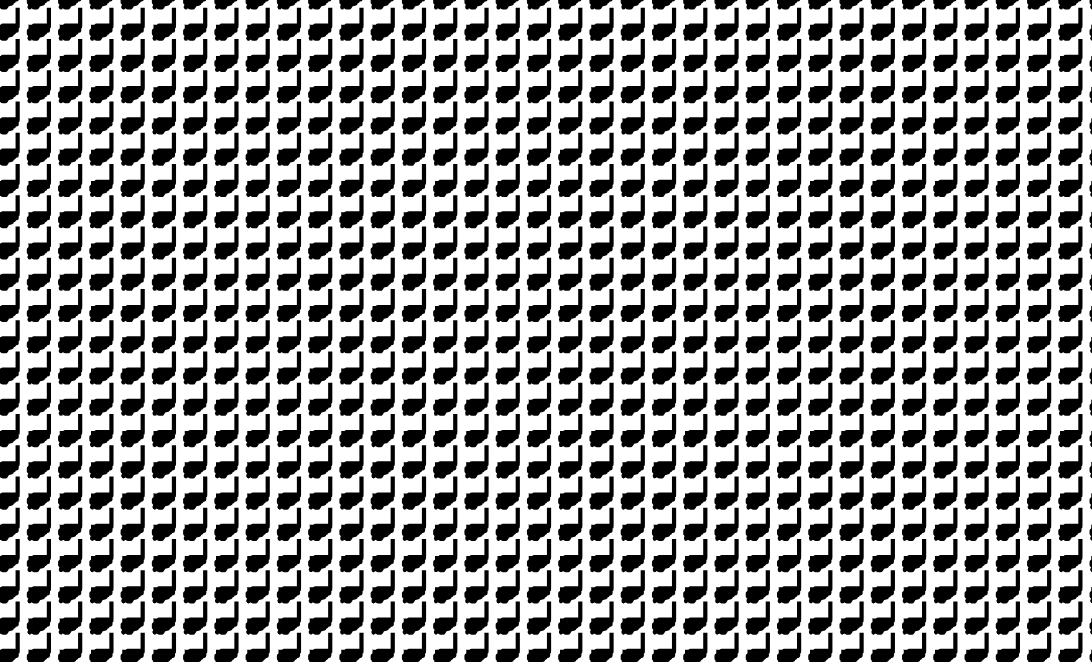

distance between metrics:  179.69550823251032


<Figure size 640x480 with 0 Axes>

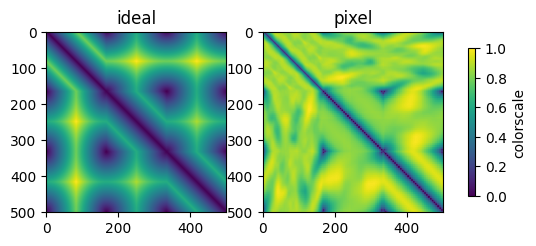

In [151]:
# Grab image from files
img = Image.open('images/C1music.png')
img = img.convert('L')
display(img)

# lens size, how much to stretch fund domain by
fund_domain = 32
a = 5
n_isoms = 500
c1_isoms_pixels = get_pixel_isom(generate_C1_isoms(n_isoms, a, a), img, fund_domain, a)

D_ideal = pairwise_distances(generate_C1_isoms(n_isoms, a, a), metric = C1_wrapper((a,0),(0,a)))
D_pixel = pairwise_distances(c1_isoms_pixels)
D_ideal = normalize(D_ideal)
D_pixel = normalize(D_pixel)
print("distance between metrics: ", dist(D_ideal.reshape(-1),D_pixel.reshape(-1)))
create_plt(D_ideal, D_pixel)

Here the pixel matrix looks very different from the ideal matrix. The upper left corner (representing the rotation cycles) seems to be hallucinating cycles. 

# C3 Comparison

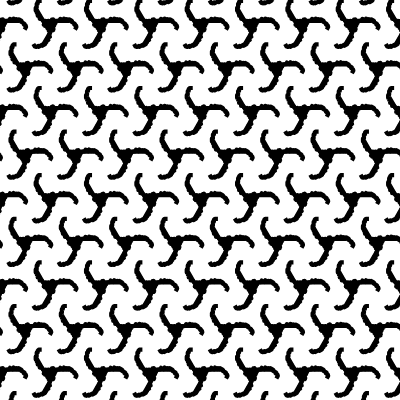

<Figure size 640x480 with 0 Axes>

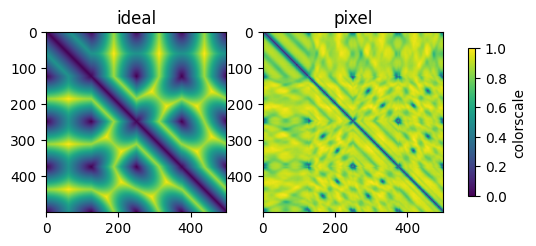

In [203]:
# Grab image from files
img = Image.open('images/C3spiral.png')
img = img.convert('L')
img = translation_snapshot(img, 400, (-15.902, 87.518))
display(img)

# lens size, how much to stretch fund domain by
fund_domain = 52
a = 2
n_isoms = 500
c3_isoms_pixels = get_pixel_isom(generate_C3_isoms(n_isoms,a), img, fund_domain, a)

D_ideal = pairwise_distances(generate_C3_isoms(n_isoms,a), metric = C3_wrapper(a))
D_pixel = pairwise_distances(c3_isoms_pixels)
D_ideal = normalize(D_ideal)
D_pixel = normalize(D_pixel)

create_plt(D_ideal, D_pixel)

Very little similarity between the pixel matrix and the idealized one. This seems to have more of what we saw with the rotation cycles in $C1$, but now almost the entire image has the marbled effect.

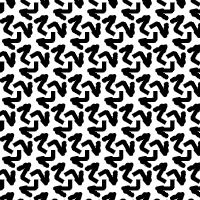

distance between metrics:  173.13569619915296


<Figure size 640x480 with 0 Axes>

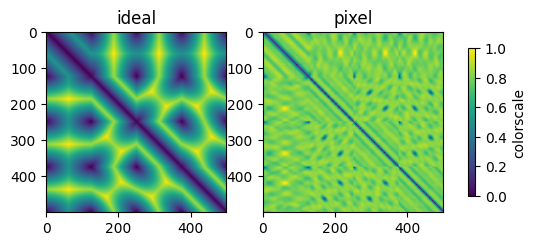

In [204]:
# Grab image from files
img = Image.open('images/C3keith.png')
img = img.convert('L')
img = translation_snapshot(img, 200, (11.948, -8.717))
display(img)

# lens size, how much to stretch fund domain by
fund_domain = 32
a = 2
n_isoms = 500
c3_isoms_pixels = get_pixel_isom(generate_C3_isoms(n_isoms,a), img, fund_domain, a)

D_ideal = pairwise_distances(generate_C3_isoms(n_isoms,a), metric = C3_wrapper(a))
D_pixel = pairwise_distances(c3_isoms_pixels)
D_ideal = normalize(D_ideal)
D_pixel = normalize(D_pixel)
print("distance between metrics: ", dist(D_ideal.reshape(-1),D_pixel.reshape(-1)))

create_plt(D_ideal, D_pixel)

Again, even with a different image we get a very similar result. 

# C6 Comparison

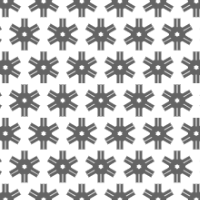

distance between metrics:  199.41303543734972


<Figure size 640x480 with 0 Axes>

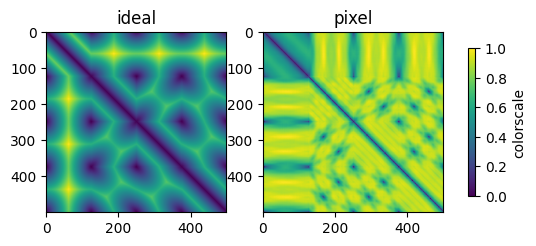

In [210]:
# Grab image from files
img = Image.open('images/C6 star.png')
img = img.convert('L')
img = translation_snapshot(img, 200, (58.113, 1.347))
display(img)

# lens size, how much to stretch fund domain by
fund_domain = 38
a = .5
n_isoms = 500
#print(generate_C6_isoms(n_isoms,a))
c6_isoms_pixels = get_pixel_isom(generate_C6_isoms(n_isoms,a), img, fund_domain, a)
D_ideal = pairwise_distances(generate_C6_isoms(n_isoms,a), metric = C6_wrapper(a))
D_pixel = pairwise_distances(c6_isoms_pixels)
D_ideal = normalize(D_ideal)
D_pixel = normalize(D_pixel)
print("distance between metrics: ", dist(D_ideal.reshape(-1),D_pixel.reshape(-1)))

create_plt(D_ideal, D_pixel)

The pixel matric looks clear but is very different from the ideal matrix. Lets try setting $a=2$.

distance between metrics:  168.41528722125625


<Figure size 640x480 with 0 Axes>

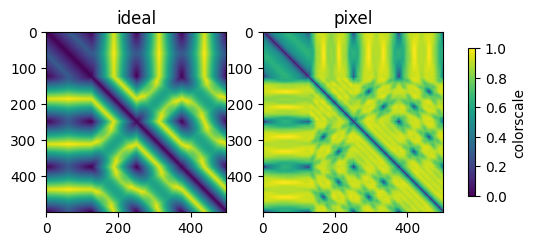

In [212]:
# lens size, how much to stretch fund domain by
fund_domain = 38
a = 2
n_isoms = 500
#print(generate_C6_isoms(n_isoms,a))
c6_isoms_pixels = get_pixel_isom(generate_C6_isoms(n_isoms,a), img, fund_domain, a)
D_ideal = pairwise_distances(generate_C6_isoms(n_isoms,a), metric = C6_wrapper(a))
D_pixel = pairwise_distances(c6_isoms_pixels)
D_ideal = normalize(D_ideal)
D_pixel = normalize(D_pixel)
print("distance between metrics: ", dist(D_ideal.reshape(-1),D_pixel.reshape(-1)))

create_plt(D_ideal, D_pixel)

Here it is more appearant that the pixel matrix has some of the same defining features as the ideal matrix on the top and left sides. For idealized distance functions, we can change the value of $a$ until we get a clear persistent homology. However, with the pixel embeddings, we can't adjust $a$, and so some images don't produce clear results. 

The $C_6$ and $C_4$ pixel matrices are much more clear and similar to their ideal matrices than the other point group, which is why TDA is able to identify those groups more consistently. 